In [39]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import scipy as sp
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import timeit
import pickle
from sklearn.calibration import calibration_curve


from deep_bayes.models import DeepEvidentialModel, MCDropOutModel, SoftmaxModel, VAE
from deep_bayes.settings import EVIDENTIAL_JUMP
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix
from deep_bayes.diagnostics import accuracy, expected_calibration_error, overconfidence

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
tf.enable_eager_execution()

In [4]:
%matplotlib inline

# Generative model specifications

In [5]:
def load_test_data(to_tensor=True):
    """Loads the common test data for all models."""
    
    test_data = pickle.load(open('sim_data/test_memory.pkl', 'rb+'))
    
    if to_tensor:
        test_data['m'] = tf.convert_to_tensor(test_data['m'], dtype=tf.float32)
        test_data['x'] = tf.convert_to_tensor(test_data['x'], dtype=tf.float32)
    
    return test_data

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [6]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [7]:
def model1_params_prior(**args):
    """
    Samples from the prior of the REM model theta = (g,u,c)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.random.uniform(0, 100)
    return np.array([theta])


def model2_params_prior(**args):
    """
    Samples from the prior of the BCDMEM model theta = (g,u,c)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    theta = np.random.uniform(0, 100)
    return np.array([theta])

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|\boldsymbol{\theta},\boldsymbol{m}).$

In [107]:
def h(x, pre, c):
    return (x**pre).prod(1) * c

def gillespie(x, c, pre, post, max_t):
    """
    Gillespie simulation

    Parameters
    ----------

    x: 1D array of size n_species
        The initial numbers.

    c: 1D array of size n_reactions
        The reaction rates.

    pre: array of size n_reactions x n_species
        What is to be consumed.

    post: array of size n_reactions x n_species
        What is to be produced

    max_t: int
        Timulate up to time max_t

    Returns
    -------
    t, X: 1d array, 2d array
        t: The time points.
        X: The history of the species.
           ``X.shape == (t.size, x.size)``

    """
    t = 0
    t_store = [t]
    x_store = [x.copy()]
    S = post - pre

    while t < max_t:
        h_vec = h(x, pre, c)
        h0 = h_vec.sum()
        if h0 == 0:
            break
        delta_t = np.random.exponential(1 / h0)
        # no reaction can occur any more
        if not np.isfinite(delta_t):
            t_store.append(max_t)
            x_store.append(x)
            break
        reaction = sp.random.choice(c.size, p=h_vec/h0)
        t = t + delta_t
        x = x + S[reaction]

        t_store.append(t)
        x_store.append(x)

    return np.asarray(t_store), np.asarray(x_store)


def model1(theta, max_t=0.1):

    x0 = np.array([40, 3])  
    pre = np.array([[1, 1]], dtype=np.int32)
    post = np.array([[0, 2]])
    t, X = gillespie(x0, theta, pre, post, max_t)
    
    if t.shape[0] < 41:
        t = np.append(t, [t[-1]] * (41 - t.shape[0]))
        X = np.append(X, [X[-1]] * (41 - X.shape[0]), axis=0)
    
    return np.c_[t, X / 41]

def model2(theta, max_t=0.1):

    x0 = np.array([40, 3])  
    pre = np.array([[1, 0]], dtype=np.int32)
    post = np.array([[0, 1]])
    t, X = gillespie(x0, theta, pre, post, max_t)
    
    if t.shape[0] < 41:
        t = np.append(t, [t[-1]] * (41 - t.shape[0]))
        X = np.append(X, [X[-1]] * (41 - X.shape[0]), axis=0)
    
    return np.c_[t, X / 41]

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [9]:
def data_generator(batch_size, model_prior, param_priors, forward_models, alpha_smooth=None,
                   t_max=0.1, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    alpha_smooth   : float or None -- the label smoothing hyperparameter
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, t_max)
        
        # Store data and params
        x.append(x_m)
        theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Stote x into a tensor
    x = np.array(x)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'theta': theta, 'x': x}

# Training hyperparameters

In [10]:
#--- Training hyperparameters ---#
ckpt_file = "jump_model_evidential"
batch_size = 32
epochs = 50
iterations_per_epoch = 1000
n_test = 500
alpha_smooth = None


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0001
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#
model_names = [r'$\mathcal{M}_1$', r'$\mathcal{M}_2$'] 
param_priors = [model1_params_prior, model2_params_prior]
forward_models = [model1, model2]

data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   alpha_smooth=alpha_smooth)

## Create model

In [11]:
model = DeepEvidentialModel(EVIDENTIAL_JUMP)

## Manage checkpoints

In [12]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [14]:
test_data = data_gen(500)

## Train network

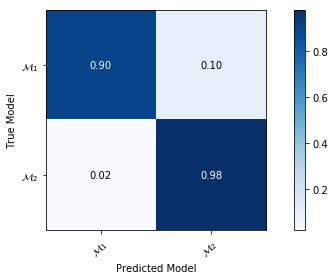

0.944



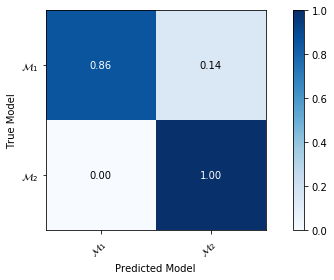

0.932



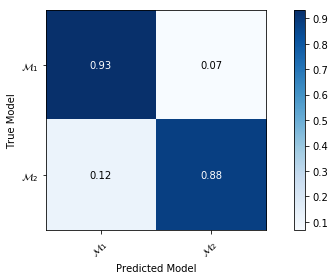

0.906



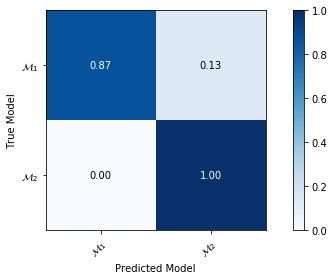

0.936



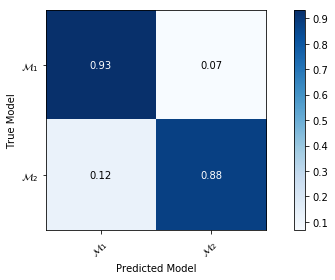

0.904



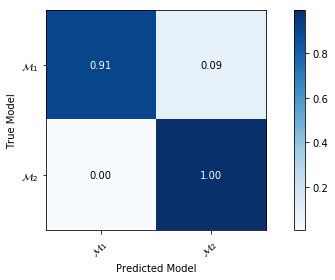

0.956



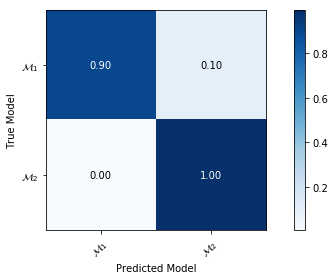

0.952



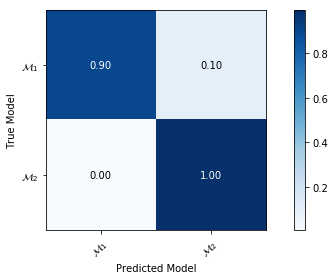

0.952



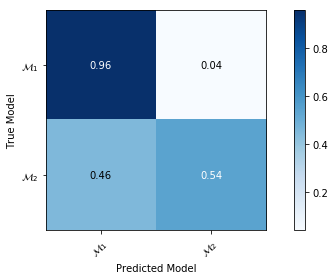

0.744



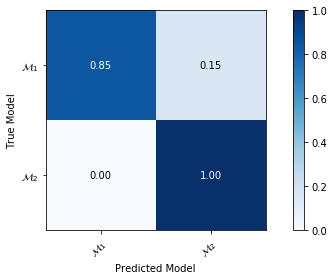

0.928



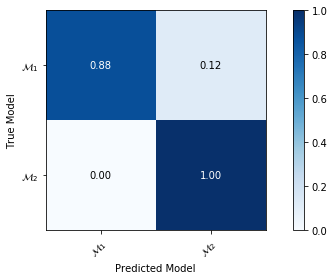

0.942



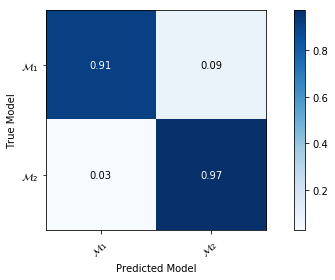

0.944



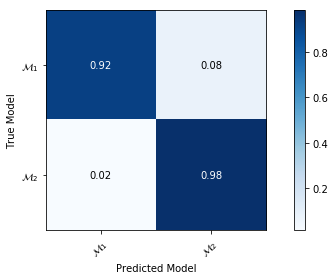

0.954



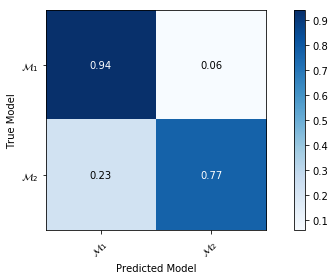

0.854



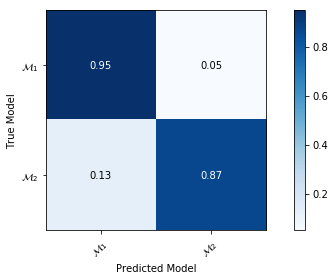

0.908



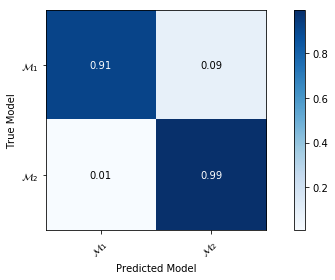

0.954



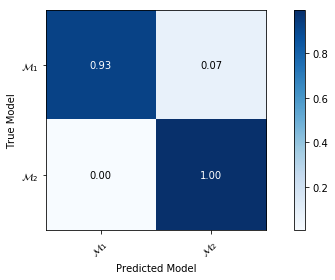

0.962



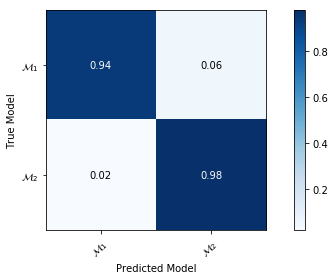

0.96



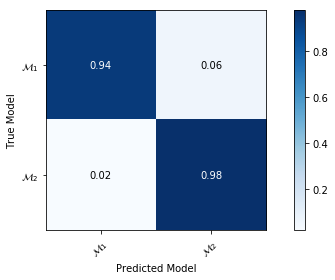

0.962



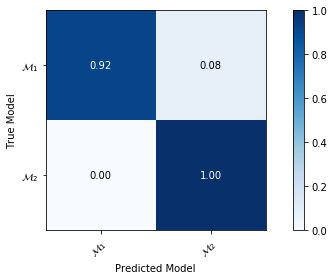

0.962



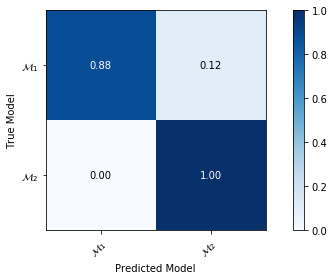

0.944



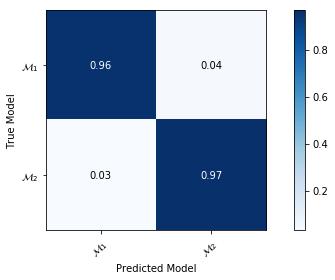

0.964



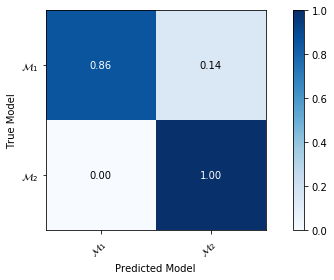

0.932



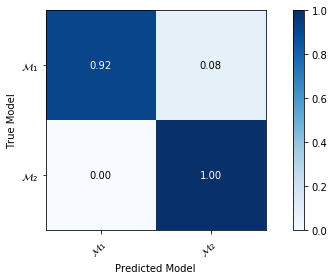

0.96



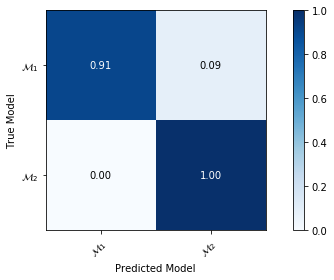

0.958



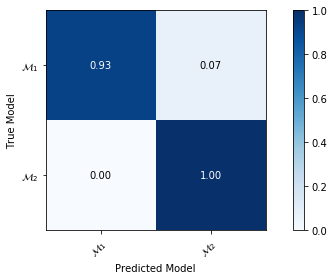

0.966



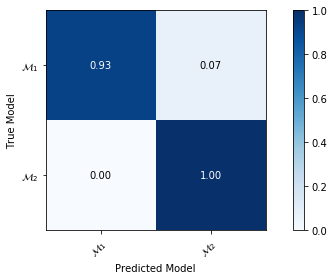

0.966



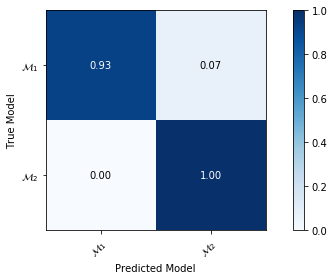

0.966



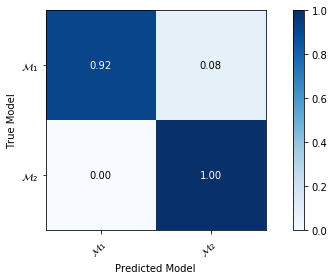

0.96



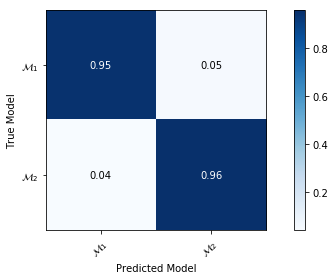

0.954



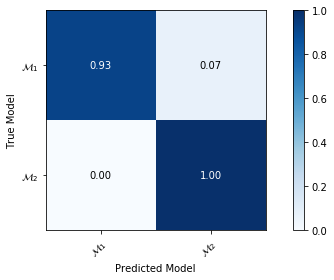

0.964



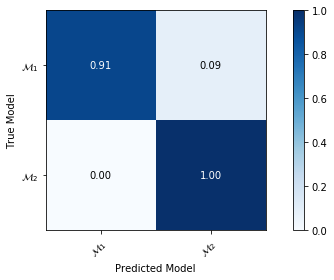

0.958



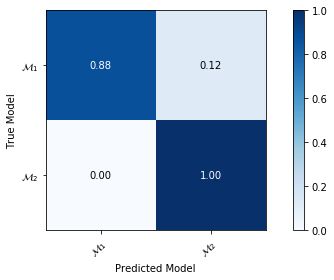

0.94



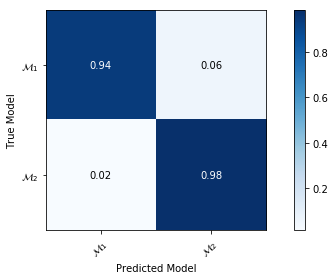

0.964



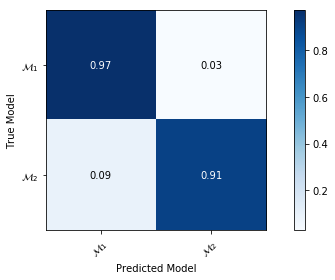

0.938



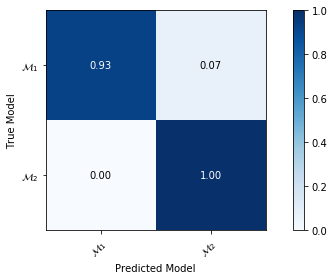

0.966



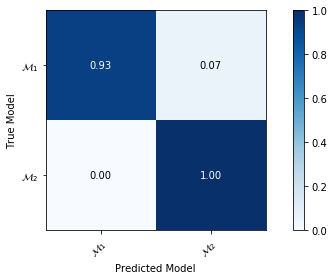

0.968



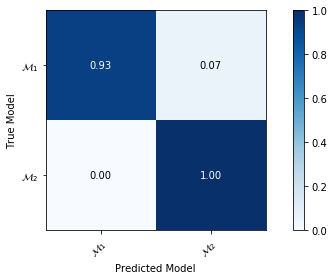

0.968



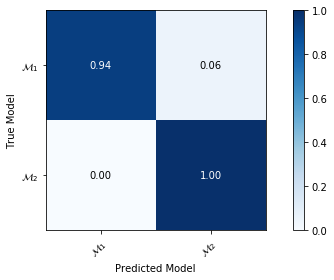

0.972



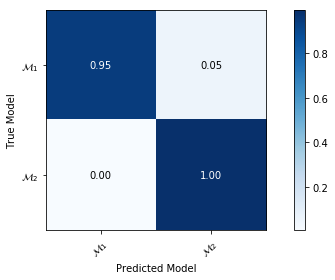

0.972



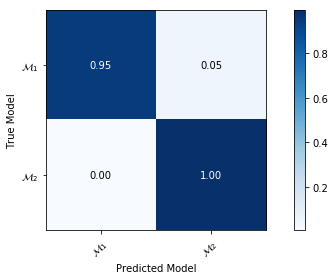

0.974



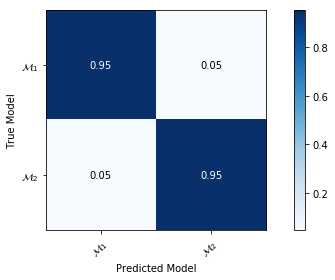

0.952



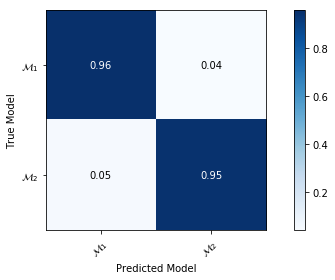

0.954



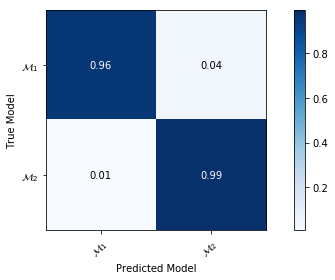

0.978



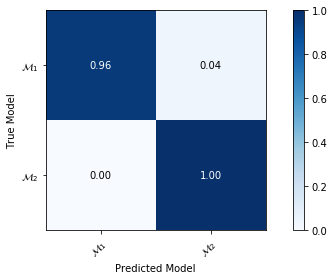

0.98



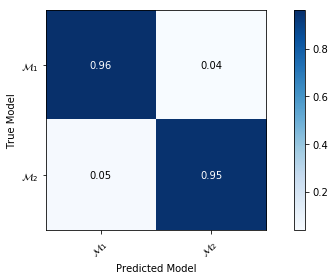

0.958



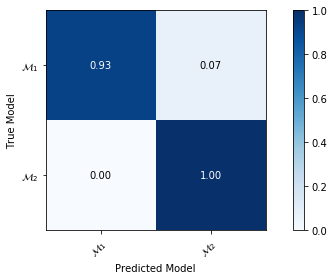

0.966



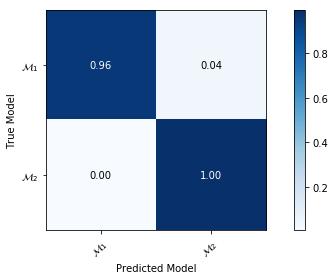

0.98



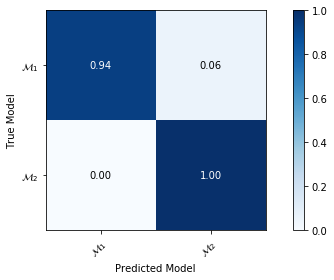

0.97



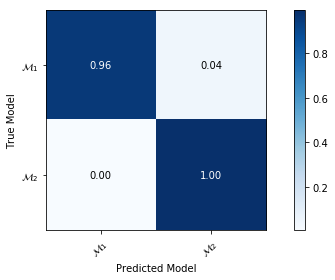

0.978

Wall time: 52min 22s


In [17]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0.00), 
                              iterations=iterations_per_epoch,
                              batch_size=1,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        
        
        # Plot stuff
        m_pred = model(test_data['x'])['m_probs']
        plot_confusion_matrix(m_pred.numpy().argmax(axis=1), test_data['m'], model_names, figsize=(8,4),normalize=True)
        print(accuracy(test_data['m'], m_pred))

        # Store checkpoint
        manager.save()

In [18]:
%%time
m_pred = model(test_data['x'])['m_probs']

Wall time: 254 ms


In [24]:
accs = []
n_bootstrap = 100
for i in range(n_bootstrap):
    b_idx = np.random.choice(np.random.permutation(500), size=500, replace=True)
    x_b = tf.gather(test_data['x'], b_idx, axis=0)
    m_b = tf.gather(test_data['m'], b_idx, axis=0)
    m_pred = model(x_b)['m_probs']
    acc_b = accuracy(m_b, m_pred)
    accs.append(acc_b)

Text(0, 0.5, 'Confidence')

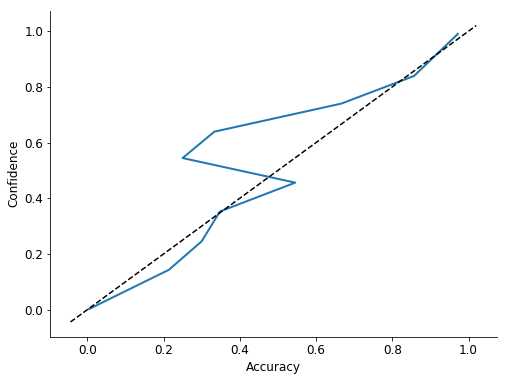

In [40]:
n_chunks = 10
test_data_c = data_gen(5000)
preds = np.concatenate([model.predict(x, to_numpy=True)['m_probs'] 
                        for x in tf.split(test_data_c['x'], n_chunks, axis=0)], axis=0)


plt.rcParams['font.size'] = 12
f, ax = plt.subplots(1, 1, figsize=(8, 6))
prob_true, prob_pred = calibration_curve(test_data_c['m'].numpy().argmax(axis=1), preds[:, 1], n_bins=10)
ax.plot(prob_true, prob_pred, lw=2)
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Confidence')

# Py-ABC comparison
"""
Example taken from:

https://pyabc.readthedocs.io/en/latest/examples/chemical_reaction.html

"""

In [23]:
import pyabc
from pyabc import Distribution, RV
from pyabc import ABCSMC
from pyabc.populationstrategy import AdaptivePopulationSize
import tempfile
import os

In [6]:
def h(x, pre, c):
    return (x**pre).prod(1) * c

def gillespie(x, c, pre, post, max_t):
    """
    Gillespie simulation

    Parameters
    ----------

    x: 1D array of size n_species
        The initial numbers.

    c: 1D array of size n_reactions
        The reaction rates.

    pre: array of size n_reactions x n_species
        What is to be consumed.

    post: array of size n_reactions x n_species
        What is to be produced

    max_t: int
        Timulate up to time max_t

    Returns
    -------
    t, X: 1d array, 2d array
        t: The time points.
        X: The history of the species.
           ``X.shape == (t.size, x.size)``

    """
    t = 0
    t_store = [t]
    x_store = [x.copy()]
    S = post - pre

    while t < max_t:
        h_vec = h(x, pre, c)
        h0 = h_vec.sum()
        if h0 == 0:
            break
        delta_t = sp.random.exponential(1 / h0)
        # no reaction can occur any more
        if not sp.isfinite(delta_t):
            t_store.append(max_t)
            x_store.append(x)
            break
        reaction = sp.random.choice(c.size, p=h_vec/h0)
        t = t + delta_t
        x = x + S[reaction]

        t_store.append(t)
        x_store.append(x)

    return sp.asarray(t_store), sp.asarray(x_store)

In [8]:
MAX_T = 0.1

class Model1:
    __name__ = "Model 1"
    x0 = sp.array([40, 3])   # Initial molecule numbers
    pre = sp.array([[1, 1]], dtype=int)
    post = sp.array([[0, 2]])


    def __call__(self, par):
        t, X = gillespie(self.x0,
                         sp.array([float(par["rate"])]),
                         self.pre, self.post,
                         MAX_T)
        return {"t": t, "X" : X}

class Model2(Model1):
    __name__ = "Model 2"
    pre = sp.array([[1, 0]], dtype=int)
    post = sp.array([[0, 1]])

In [ ]:
# Evidential probs
np.random.seed(123)
x = model1(np.array([2.5]))
x_tensor = tf.convert_to_tensor(x[np.newaxis], dtype=tf.float32)
print(model(x_tensor)['m_probs'])

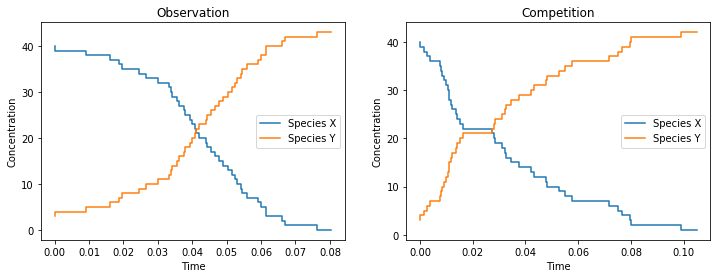

In [9]:
true_rate = 2.5
observations = [Model1()({"rate": true_rate}),
                Model2()({"rate": 30})]
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches((12, 4))
for ax, title, obs in zip(axes, ["Observation", "Competition"],
                          observations):
    ax.step(obs["t"], obs["X"])
    ax.legend(["Species X", "Species Y"])
    ax.set_xlabel("Time")
    ax.set_ylabel("Concentration")
    ax.set_title(title)

In [10]:
N_TEST_TIMES = 20

t_test_times = sp.linspace(0, MAX_T, N_TEST_TIMES)
def distance(x, y):
    xt_ind = sp.searchsorted(x["t"], t_test_times) - 1
    yt_ind = sp.searchsorted(y["t"], t_test_times) - 1
    error = (sp.absolute(x["X"][:,1][xt_ind]
                        - y["X"][:,1][yt_ind]).sum()
             / t_test_times.size)
    return error

In [20]:
prior = Distribution(rate=RV("uniform", 0, 100))

In [24]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "mjp.db"))

abc = ABCSMC([Model1(),
              Model2()],
             [prior, prior],
             distance,
             population_size=AdaptivePopulationSize(500, 0.15))

In [27]:
abc_id = abc.new(db_path, observations[0])

INFO:History:Start <ABCSMC(id=1, start_time=2020-03-22 19:18:09.672492, end_time=None)>


In [28]:
%%time
history = abc.run(minimum_epsilon=0.7, max_nr_populations=10)

INFO:Epsilon:initial epsilon is 14.924999999999992
INFO:ABC:t:0 eps:14.924999999999992
INFO:ABC:t:1 eps:10.7
INFO:Adaptation:Change nr particles 500 -> 74
INFO:ABC:t:2 eps:8.797417110092152
INFO:Adaptation:Change nr particles 74 -> 78
INFO:ABC:t:3 eps:7.045420643644404
INFO:Adaptation:Change nr particles 78 -> 84
INFO:ABC:t:4 eps:6.2
INFO:Adaptation:Change nr particles 84 -> 93
INFO:ABC:t:5 eps:5.8
INFO:Adaptation:Change nr particles 93 -> 86
INFO:ABC:t:6 eps:5.1401726290108085
INFO:Adaptation:Change nr particles 86 -> 90
INFO:ABC:t:7 eps:4.45
INFO:Adaptation:Change nr particles 90 -> 111
INFO:ABC:t:8 eps:3.1
INFO:Adaptation:Change nr particles 111 -> 84
INFO:ABC:t:9 eps:2.4
INFO:Adaptation:Change nr particles 84 -> 57
INFO:ABC:t:10 eps:1.85
INFO:Adaptation:Change nr particles 57 -> 53
INFO:ABC:t:11 eps:1.457287647661789
INFO:Adaptation:Change nr particles 53 -> 66
INFO:ABC:t:12 eps:1.25
INFO:Adaptation:Change nr particles 66 -> 53
INFO:ABC:t:13 eps:1.0195262985587572
INFO:Adaptation:C

Wall time: 12min 11s


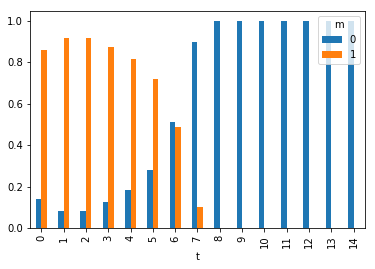

In [29]:
history.get_model_probabilities().plot.bar();

In [30]:
history.get_model_probabilities()

m,0,1
t,,
0,0.140000,0.860000
1,0.083693,0.916307
2,0.082143,0.917857
3,0.123808,0.876192
4,0.185994,0.814006
5,0.281537,0.718463
6,0.510507,0.489493
7,0.900116,0.099884
8,1.000000,0.000000
